In [30]:
import torch
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO
import pandas as pd
from torch.distributions import constraints
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [31]:
dict_rest = pd.read_pickle("./data/crawled_data.pickle")

In [56]:
# organize data 
ids = [d["id"] for d in dict_rest]
names = [d["name"] for d in dict_rest]
lats = [d["coordinates"]["lat"] for d in dict_rest]
lngs = [d["coordinates"]["lng"] for d in dict_rest]
ratings = [ d["rating"] for d in dict_rest]
#taking log
rating_ns = np.log([d["rating_n"] for d in dict_rest])
populartimes = [ d["populartimes"] for d in dict_rest]
poptime_sat = [ d[5]['data'] for d in populartimes]
poptime_sat_12 = [d[12] for d in poptime_sat]

In [57]:
selected_data = {'ids':ids,'names':names,'lats':lats,'lngs':lngs,\
                 'ratings':ratings,'rating_ns':rating_ns,'poptime_sat_12':poptime_sat_12}
df = pd.DataFrame(selected_data)
df_model = df[['ratings','rating_ns','poptime_sat_12']]
train_data = torch.tensor(df_model.values, dtype = torch.float)
rating, rating_ns, popularity = train_data[:, 0], torch.log(train_data[:,1]), train_data[:,2]

In [58]:
# #Tested whether SVI runs correctly, and it did.
# rating = torch.rand(30)
# test_dist = dist.Poisson(torch.exp(rating.sum() + 1))
# popularity = torch.tensor([test_dist.sample() for i in range(len(rating))], dtype = torch.float)

In [59]:
def model(data, ratings):
    betas = []

    #bias
    betas.append(pyro.sample("beta_0", dist.Normal(0, 1)))
    #make one-hot vector length betas
    for i in range(len(data)):
        betas.append(pyro.sample("beta_{}".format(i + 1), dist.Normal(0, 1)))

    betas = np.array(betas, dtype = object)
    lambda_ = torch.exp(betas * data)
    
    with pyro.plate("ratings", len(popularity)):
        y = pyro.sample("obs", dist.Poisson(lambda_), obs = ratings)
    
    return y

In [62]:
# def guide(rating, rating_ns, popularity):
#     weights_loc = pyro.param('weights_loc', torch.randn(3))
#     weights_scale = pyro.param('weights_scale', torch.ones(3), constraint=constraints.positive)        
# #     weights_loc = pyro.param('weights_loc', torch.randn(2))
# #     weights_scale = pyro.param('weights_scale', torch.ones(2), constraint=constraints.positive)        

    
#     beta_0 = pyro.sample("beta_0", dist.Normal(weights_loc[0], weights_scale[0]))
#     beta_1 = pyro.sample("beta_1", dist.Normal(weights_loc[1], weights_scale[1]))
#     beta_2 = pyro.sample("beta_2", dist.Normal(weights_loc[2], weights_scale[2]))
#     labmda_ = torch.exp(beta_0 + beta_1 * rating + beta_2 * rating_ns)
# #     labmda_ = torch.exp(beta_0 + beta_1 * rating)

# guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

In [63]:
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=JitTrace_ELBO(), 
          num_samples=1000)

pyro.clear_param_store()
epoch = 10000
for i in range(epoch):
    ELBO = svi.step(rating, rating_ns, popularity)
    if i % 500 == 0:
        print(ELBO)
posterior = svi.run(rating, rating_ns, popularity)


/Users/wonjunson/anaconda3/envs/pp/lib/python3.7/site-packages/ipykernel_launcher.py:8: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  


189419.453125
188948.203125
34330.90625
235226.765625
54054.26953125
76167.7421875
94264.296875
82095.7890625
67832.1015625
35152.9765625
18433.05078125
10774.3125
15262.83203125
70422.390625
9855.8173828125
9606.08203125
10324.0419921875
10948.9326171875
10629.529296875
9985.5615234375
9885.2890625
9539.390625
10016.080078125
9368.796875
9449.01171875
9624.943359375
9442.1884765625
9588.521484375
9390.576171875
9390.4677734375
9835.7666015625
9402.53125
9493.5478515625
10512.8681640625
9546.017578125
9371.4443359375
9364.73828125
9366.73828125
9410.8701171875
9340.99609375
9390.248046875
9356.5390625
9400.7412109375
9397.7919921875
9336.392578125
9346.869140625
9355.7373046875
9330.203125
9339.470703125
9340.728515625
9342.494140625
9338.3994140625
9340.7470703125
9341.69921875
9335.6025390625
9391.947265625
9335.5556640625
9340.63671875
9333.3466796875
9336.4208984375
9476.3017578125
9331.9423828125
9354.458984375
9333.8203125
9334.7333984375
9331.8349609375
9332.423828125
9331.55175

In [9]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(rating, rating_ns, popularity)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 1200/1200 [01:31<00:00, 13.17it/s, step size=5.71e-02, acc. prob=0.922]


In [10]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


In [16]:

svi_diagnorm_posterior = svi.run(rating,rating_ns,popularity)
sites = ["beta_0", "beta_1","beta_2"]

svi_samples = {site: EmpiricalMarginal(svi_diagnorm_posterior, sites=site)
                     .enumerate_support().detach().cpu().numpy()
               for site in sites}
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta_0
       mean       std        5%      25%       50%       75%       95%
0  2.516612  0.007422  2.504562  2.51175  2.516841  2.521283  2.528724 

Site: beta_1
       mean       std       5%       25%       50%       75%       95%
0 -0.124756  0.001868 -0.12784 -0.125988 -0.124778 -0.123518 -0.121681 

Site: beta_2
     mean       std        5%      25%       50%       75%       95%
0  0.2374  0.001166  0.235513  0.23664  0.237381  0.238175  0.239374 



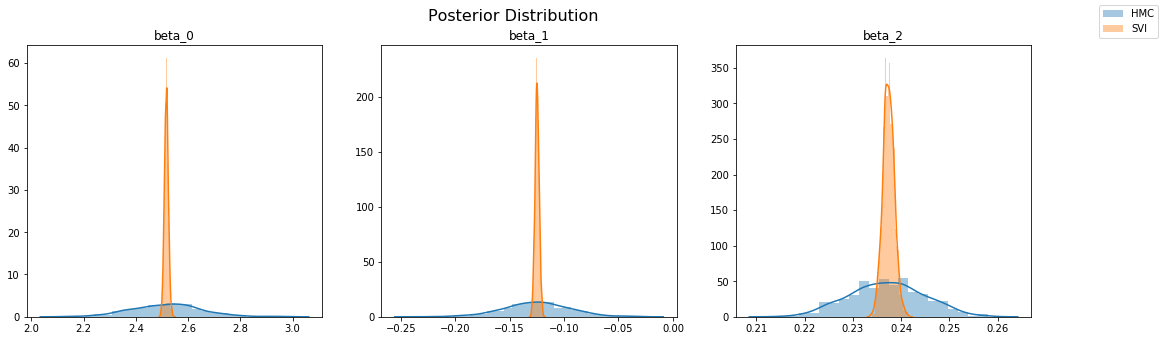

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.suptitle("Posterior Distribution", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    try:
        site = sites[i]
        sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
        sns.distplot(svi_samples[site], ax=ax, label="SVI")
        ax.set_title(site)
    except:
        pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [65]:
# #MLE

# #variables
# MLE_thetas = torch.ones(train_data.shape[1] - 1, requires_grad = True)
# def neg_log_likelihood(x,y):
#     theta_times_x = MLE_thetas * x
#     log_likelihood = torch.sum(y * theta_times_x - torch.exp(theta_times_x))
#     return -log_likelihood

# def get_MLE(x, y):
#     epoch = 10000
#     optimizer = torch.optim.Adam([MLE_thetas])
#     for i in range(epoch):

#         optimizer.zero_grad()
#         target = neg_log_likelihood(x,y)
#         target.backward()
#         optimizer.step()

# get_MLE(train_data[:,:2],train_data[:,2:])

In [66]:
MLE_thetas

tensor([0.7945, 0.5504], requires_grad=True)

In [67]:
#MLE

#variables
MLE_thetas = torch.ones(1, requires_grad = True)
def neg_log_likelihood(x,y):
    theta_times_x = MLE_thetas * x
    log_likelihood = torch.sum(y * theta_times_x - torch.exp(theta_times_x))
    return -log_likelihood

def get_MLE(x, y):
    epoch = 10000
    optimizer = torch.optim.Adam([MLE_thetas])
    for i in range(epoch):

        optimizer.zero_grad()
        target = neg_log_likelihood(x,y)
        target.backward()
        optimizer.step()

get_MLE(train_data[:,:1],train_data[:,2:])

In [72]:
res = pyro.distributions.Poisson(MLE_thetas)

In [79]:
res()

tensor([1.])